<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/CNN_LSTM_P_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [1]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 9.8 MB/s 
     |████████████████████████████████| 210 kB 35.4 MB/s 
     |████████████████████████████████| 81 kB 12.1 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 147 kB 34.9 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 112 kB 33.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=2855a6c87f68fe4b1f93caf6f52ee77c36e08290a75e891cfee4dfe747e6a694
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unins

In [2]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [4]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [5]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [6]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [7]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [8]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [9]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [11]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [12]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [13]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [14]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [15]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

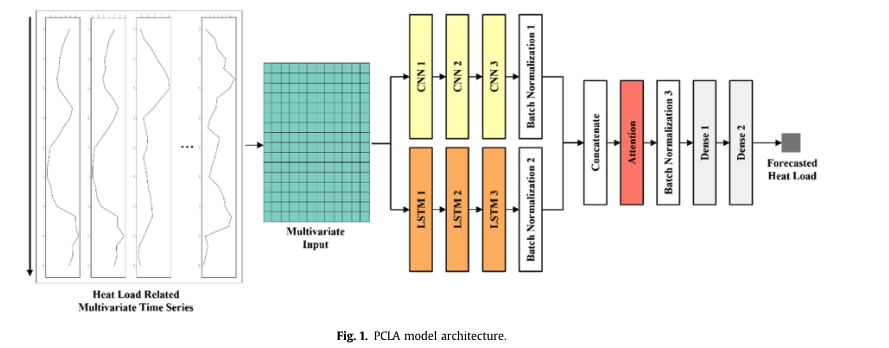


The following structure is based on the paper: https://www.sciencedirect.com/science/article/pii/S0360544222002535


* Note that I do not consider the batch normalization in my code.
* The parallel structure without the attention layer is also coded.(the first code section)


In [ ]:
class CNNLSTMP(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size1=9, kernel_size2=9, kernel_size3=9,
                 n_channels1=64, n_channels2=128, n_channels3=128,
                 hidden_size1= 256, hidden_size2= 256, hidden_size3= 256, seq_len=72):
        super(CNNLSTMP, self).__init__()
        
        #CNN part 
        self.conv1 = nn.Conv1d(input_dim, n_channels1, kernel_size=kernel_size1)     #the first convolution layer
        self.zp1 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  

        self.conv2 = nn.Conv1d(n_channels1, n_channels2, kernel_size=kernel_size2)   #the second convolution layer
        self.zp2 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  

        self.conv3 = nn.Conv1d(n_channels2, n_channels3, kernel_size=kernel_size3)   #the second convolution layer
        self.zp3 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output

        #LSTM part
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_size1)         #The first LSTM layer 
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2)      #The first LSTM layer 
        self.lstm3 = nn.LSTM(input_size=hidden_size2, hidden_size=hidden_size3)      #The first LSTM layer 

        #Dense layer
        self.linear1 = nn.Linear((hidden_size3+n_channels3)*seq_len, 120)      
        self.linear2 = nn.Linear(120, output_dim)          

    def forward(self, x):
        y1 = x.permute(0, 2, 1)
        y2 = x

        y1 = self.zp1(y1)
        y1 = torch.relu(self.conv1(y1))

        y1 = self.zp2(y1)
        y1 = torch.relu(self.conv2(y1))

        y1 = self.zp3(y1)
        y1 = torch.relu(self.conv3(y1))
        y1 = y1.permute(0, 2, 1) 

        y2, (_, _) = self.lstm1(y2)
        y2, (_, _) = self.lstm2(y2)
        y2, (_, _) = self.lstm3(y2)

        merged = torch.cat((y1, y2), 2)
        out = torch.flatten(merged, start_dim=1)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

In [16]:
#attention mechnism code

class TemporalAttn(nn.Module):
    def __init__(self, hidden_size):
        super(TemporalAttn, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc2 = nn.Linear(self.hidden_size*2, self.hidden_size, bias=False)

    def forward(self, hidden_states):
        # (batch_size, time_steps, hidden_size)
        score_first_part = self.fc1(hidden_states)
        
        # (batch_size, hidden_size)
        h_t = hidden_states[:,-1,:]
        
        # (batch_size, time_steps)
        score = torch.bmm(score_first_part, h_t.unsqueeze(2)).squeeze(2)
        attention_weights = F.softmax(score, dim=1)
        
        # (batch_size, hidden_size)
        context_vector = torch.bmm(hidden_states.permute(0,2,1), attention_weights.unsqueeze(2)).squeeze(2)

        # (batch_size, hidden_size*2)
        pre_activation = torch.cat((context_vector, h_t), dim=1)
        
        # (batch_size, hidden_size)
        attention_vector = self.fc2(pre_activation)
        attention_vector = torch.tanh(attention_vector)

        return attention_vector, attention_weights

In [17]:
class CNNLSTMATT(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size1=9, kernel_size2=9, kernel_size3=9,
                 n_channels1=64, n_channels2=128, n_channels3=128,
                 hidden_size1= 256, hidden_size2= 256, hidden_size3= 256, seq_len=72):
        super(CNNLSTMATT, self).__init__()
        
        #CNN part 
        self.conv1 = nn.Conv1d(input_dim, n_channels1, kernel_size=kernel_size1)     #the first convolution layer
        self.zp1 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  

        self.conv2 = nn.Conv1d(n_channels1, n_channels2, kernel_size=kernel_size2)   #the second convolution layer
        self.zp2 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  

        self.conv3 = nn.Conv1d(n_channels2, n_channels3, kernel_size=kernel_size3)   #the second convolution layer
        self.zp3 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output

        #LSTM part
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_size1)         #The first LSTM layer 
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2)      #The first LSTM layer 
        self.lstm3 = nn.LSTM(input_size=hidden_size2, hidden_size=hidden_size3)      #The first LSTM layer 

        #attention part
        self.attn = TemporalAttn(hidden_size=(hidden_size3+n_channels3))

        #Dense layer
        self.linear1 = nn.Linear((hidden_size3+n_channels3), 120)      
        self.linear2 = nn.Linear(120, output_dim)          

    def forward(self, x):
        y1 = x.permute(0, 2, 1)
        y2 = x

        y1 = self.zp1(y1)
        y1 = torch.relu(self.conv1(y1))

        y1 = self.zp2(y1)
        y1 = torch.relu(self.conv2(y1))

        y1 = self.zp3(y1)
        y1 = torch.relu(self.conv3(y1))
        y1 = y1.permute(0, 2, 1) 

        y2, (_, _) = self.lstm1(y2)
        y2, (_, _) = self.lstm2(y2)
        y2, (_, _) = self.lstm3(y2)

        merged = torch.cat((y1, y2), 2)
        out, weights = self.attn(merged)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

In [19]:
#just for checking the dimensions
x = torch.rand(64, 120, 9)

model = CNNLSTMATT(input_dim = 9, 
            output_dim=24, 
            kernel_size1=9, 
            n_channels1=32, 
            n_channels2=64, 
            seq_len=24*5)

y= model(x)
y.shape

torch.Size([64, 24])

In [20]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    
    # Generate the model.
    model = CNNLSTMATT(input_dim = 9, 
                output_dim = 24, 
                kernel_size1 = trial.suggest_int("kernel_L1", 3, 10), 
                kernel_size2 = trial.suggest_int("kernel_L2", 3, 10),
                kernel_size3 = trial.suggest_int("kernel_L3", 3, 10),
                n_channels1 = trial.suggest_int("hidden_L1", 16, 128), 
                n_channels2 = trial.suggest_int("hidden_L2", 16, 128),
                n_channels3 = trial.suggest_int("hidden_L3", 16, 128),
                hidden_size1 = trial.suggest_int("hidden_lstm_L1", 16, 128),
                hidden_size2 = trial.suggest_int("hidden_lstm_L2", 16, 128),
                hidden_size3 = trial.suggest_int("hidden_lstm_L3", 16, 128),
                seq_len=24*5).cuda() 

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "CNNLSTMP.pt")


        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)

    return min_val_loss

In [21]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=50)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    #with open("CNN.pickle".format(study.best_trial.number), "rb") as fin:
    #    best_clf = pickle.load(fin)

[I 2022-12-29 01:47:32,320] A new study created in memory with name: no-name-113fbfd4-32d2-471a-a2a8-f4215e2d5a02


Iter:  0 train:  822.3079091310501 val:  57.9756288677454
Iter:  20 train:  70.15175133943558 val:  27.927061239257455
Iter:  40 train:  60.19298226386309 val:  26.155001934617758
Iter:  60 train:  54.33461957797408 val:  23.427164832130075
Iter:  80 train:  49.82452607154846 val:  25.208673052489758


[I 2022-12-29 01:57:47,331] Trial 0 finished with value: 22.81590935960412 and parameters: {'kernel_L1': 7, 'kernel_L2': 7, 'kernel_L3': 10, 'hidden_L1': 23, 'hidden_L2': 127, 'hidden_L3': 36, 'hidden_lstm_L1': 74, 'hidden_lstm_L2': 45, 'hidden_lstm_L3': 125, 'lr': 6.993837033510097e-05}. Best is trial 0 with value: 22.81590935960412.


Iter:  0 train:  1724.565241575241 val:  208.97444814443588
Iter:  20 train:  88.3990514203906 val:  28.856347419321537
Iter:  40 train:  74.0864117667079 val:  26.361642548814416
Iter:  60 train:  67.40257895737886 val:  26.882777273654938
Iter:  80 train:  63.56114462763071 val:  25.407875943928957
Iter:  100 train:  60.314099211245775 val:  25.287248075008392


[I 2022-12-29 02:07:55,063] Trial 1 finished with value: 24.244616584852338 and parameters: {'kernel_L1': 5, 'kernel_L2': 10, 'kernel_L3': 6, 'hidden_L1': 115, 'hidden_L2': 20, 'hidden_L3': 37, 'hidden_lstm_L1': 53, 'hidden_lstm_L2': 65, 'hidden_lstm_L3': 41, 'lr': 2.7092334981778723e-05}. Best is trial 0 with value: 22.81590935960412.


Iter:  0 train:  1938.580399632454 val:  217.39124882221222
Iter:  20 train:  93.43758966773748 val:  31.757550977170467
Iter:  40 train:  78.16829380393028 val:  30.74610734730959
Iter:  60 train:  70.62044160813093 val:  25.85205115750432
Iter:  80 train:  65.75138409435749 val:  26.114739069715142
Iter:  100 train:  62.42516806721687 val:  26.197666520252824
Iter:  120 train:  59.892438508570194 val:  26.02499531209469


[I 2022-12-29 02:28:06,568] Trial 2 finished with value: 24.684188704937696 and parameters: {'kernel_L1': 3, 'kernel_L2': 3, 'kernel_L3': 7, 'hidden_L1': 122, 'hidden_L2': 102, 'hidden_L3': 95, 'hidden_lstm_L1': 83, 'hidden_lstm_L2': 116, 'hidden_lstm_L3': 107, 'lr': 1.1035898390275672e-05}. Best is trial 0 with value: 22.81590935960412.


Iter:  0 train:  1927.8161841630936 val:  211.1815266609192
Iter:  20 train:  97.10636396706104 val:  33.97206022590399
Iter:  40 train:  78.12022177129984 val:  29.939275523647666
Iter:  60 train:  70.76133768260479 val:  27.232259053736925
Iter:  80 train:  66.29583629965782 val:  27.836461259052157
Iter:  100 train:  63.51262331008911 val:  26.27594937942922
Iter:  120 train:  60.894167721271515 val:  27.088001530617476
Iter:  140 train:  59.067789137363434 val:  25.975951239466667


[I 2022-12-29 02:41:47,191] Trial 3 finished with value: 25.01419717259705 and parameters: {'kernel_L1': 8, 'kernel_L2': 5, 'kernel_L3': 8, 'hidden_L1': 118, 'hidden_L2': 50, 'hidden_L3': 81, 'hidden_lstm_L1': 62, 'hidden_lstm_L2': 32, 'hidden_lstm_L3': 82, 'lr': 1.1467479439602284e-05}. Best is trial 0 with value: 22.81590935960412.


Iter:  0 train:  310.01051503419876 val:  33.4941494576633
Iter:  20 train:  38.661825966089964 val:  27.32722324691713


[I 2022-12-29 02:44:46,656] Trial 4 finished with value: 23.3452858440578 and parameters: {'kernel_L1': 6, 'kernel_L2': 8, 'kernel_L3': 8, 'hidden_L1': 82, 'hidden_L2': 89, 'hidden_L3': 99, 'hidden_lstm_L1': 57, 'hidden_lstm_L2': 34, 'hidden_lstm_L3': 90, 'lr': 0.00048260274581405683}. Best is trial 0 with value: 22.81590935960412.


Iter:  0 train:  1013.4415212869644 val:  88.00756368041039
Iter:  20 train:  67.97585976868868 val:  26.798829678446054
Iter:  40 train:  58.54419967159629 val:  26.119119055569172
Iter:  60 train:  54.19610919058323 val:  25.066351160407066


[I 2022-12-29 02:52:04,938] Trial 5 finished with value: 24.616769444197416 and parameters: {'kernel_L1': 4, 'kernel_L2': 8, 'kernel_L3': 4, 'hidden_L1': 94, 'hidden_L2': 76, 'hidden_L3': 105, 'hidden_lstm_L1': 105, 'hidden_lstm_L2': 59, 'hidden_lstm_L3': 64, 'lr': 4.4480265064161214e-05}. Best is trial 0 with value: 22.81590935960412.


Iter:  0 train:  275.5671507269144 val:  34.76745569333434
Iter:  20 train:  42.706465512514114 val:  27.423489412292838


[I 2022-12-29 02:56:24,372] Trial 6 finished with value: 22.913952665403485 and parameters: {'kernel_L1': 8, 'kernel_L2': 10, 'kernel_L3': 9, 'hidden_L1': 105, 'hidden_L2': 29, 'hidden_L3': 106, 'hidden_lstm_L1': 119, 'hidden_lstm_L2': 69, 'hidden_lstm_L3': 105, 'lr': 0.0008769400839010628}. Best is trial 0 with value: 22.81590935960412.


Iter:  0 train:  523.2918754070997 val:  50.03924437612295
Iter:  20 train:  67.410246681422 val:  23.720974458381534
Iter:  40 train:  58.13906238600612 val:  22.821332866325974
Iter:  60 train:  53.866035271435976 val:  22.368816934525967


[I 2022-12-29 03:05:15,891] Trial 7 finished with value: 21.48078395985067 and parameters: {'kernel_L1': 3, 'kernel_L2': 7, 'kernel_L3': 3, 'hidden_L1': 17, 'hidden_L2': 27, 'hidden_L3': 70, 'hidden_lstm_L1': 106, 'hidden_lstm_L2': 95, 'hidden_lstm_L3': 102, 'lr': 0.00025033828672271156}. Best is trial 7 with value: 21.48078395985067.


Iter:  0 train:  567.4937927424908 val:  51.37156815826893
Iter:  20 train:  63.91524111479521 val:  24.212516222149134
Iter:  40 train:  52.772249571979046 val:  22.77120130509138


[I 2022-12-29 03:10:18,111] Trial 8 finished with value: 21.140259759500623 and parameters: {'kernel_L1': 10, 'kernel_L2': 8, 'kernel_L3': 5, 'hidden_L1': 24, 'hidden_L2': 87, 'hidden_L3': 39, 'hidden_lstm_L1': 90, 'hidden_lstm_L2': 62, 'hidden_lstm_L3': 19, 'lr': 0.00022882717522074945}. Best is trial 8 with value: 21.140259759500623.


Iter:  0 train:  1493.8005771636963 val:  197.7830809354782


[I 2022-12-29 03:10:56,457] Trial 9 pruned. 


Iter:  0 train:  506.4697503596544 val:  48.35838903486729
Iter:  20 train:  53.63499967381358 val:  24.920469477772713
Iter:  40 train:  39.774252232164145 val:  29.38930283859372


[I 2022-12-29 03:14:51,112] Trial 10 finished with value: 24.601272262632847 and parameters: {'kernel_L1': 10, 'kernel_L2': 5, 'kernel_L3': 5, 'hidden_L1': 54, 'hidden_L2': 107, 'hidden_L3': 128, 'hidden_lstm_L1': 21, 'hidden_lstm_L2': 93, 'hidden_lstm_L3': 20, 'lr': 0.00016346059020235266}. Best is trial 8 with value: 21.140259759500623.


Iter:  0 train:  585.8723200410604 val:  48.293543852865696
Iter:  20 train:  61.92424714565277 val:  26.72310545668006
Iter:  40 train:  50.75538392737508 val:  22.928852634504437
Iter:  60 train:  44.30681797862053 val:  24.208230758085847


[I 2022-12-29 03:22:08,631] Trial 11 finished with value: 22.194041470065713 and parameters: {'kernel_L1': 10, 'kernel_L2': 8, 'kernel_L3': 3, 'hidden_L1': 46, 'hidden_L2': 51, 'hidden_L3': 56, 'hidden_lstm_L1': 123, 'hidden_lstm_L2': 91, 'hidden_lstm_L3': 17, 'lr': 0.0002085962330518294}. Best is trial 8 with value: 21.140259759500623.


Iter:  0 train:  613.9602230787277 val:  75.52464571595192


[I 2022-12-29 03:23:02,272] Trial 12 pruned. 


Iter:  0 train:  629.868878275156 val:  49.621787041425705


[I 2022-12-29 03:25:33,674] Trial 13 pruned. 


Iter:  0 train:  522.3228313922882 val:  50.095382273197174
Iter:  20 train:  66.60149432718754 val:  24.889113638550043
Iter:  40 train:  57.76390566304326 val:  24.293785333633423
Iter:  60 train:  51.74728063866496 val:  23.009472323581576
Iter:  80 train:  47.130064371973276 val:  23.346523758023977


[I 2022-12-29 03:34:36,305] Trial 14 finished with value: 22.168221009895205 and parameters: {'kernel_L1': 9, 'kernel_L2': 6, 'kernel_L3': 5, 'hidden_L1': 32, 'hidden_L2': 33, 'hidden_L3': 18, 'hidden_lstm_L1': 112, 'hidden_lstm_L2': 81, 'hidden_lstm_L3': 38, 'lr': 0.0003611273900189976}. Best is trial 8 with value: 21.140259759500623.


Iter:  0 train:  324.02235197275877 val:  41.18649322167039
Iter:  20 train:  51.624856010079384 val:  24.76489369943738


[I 2022-12-29 03:39:28,469] Trial 15 finished with value: 23.640762772411108 and parameters: {'kernel_L1': 6, 'kernel_L2': 6, 'kernel_L3': 3, 'hidden_L1': 43, 'hidden_L2': 91, 'hidden_L3': 75, 'hidden_lstm_L1': 38, 'hidden_lstm_L2': 105, 'hidden_lstm_L3': 101, 'lr': 0.0008342209842754098}. Best is trial 8 with value: 21.140259759500623.


Iter:  0 train:  920.2227254509926 val:  74.9434594810009


[I 2022-12-29 03:40:15,285] Trial 16 pruned. 


Iter:  0 train:  560.9456688165665 val:  42.791736394166946
Iter:  20 train:  61.160543117672205 val:  23.626252016052604


[I 2022-12-29 03:43:42,793] Trial 17 finished with value: 22.42450183816254 and parameters: {'kernel_L1': 9, 'kernel_L2': 3, 'kernel_L3': 4, 'hidden_L1': 71, 'hidden_L2': 61, 'hidden_L3': 66, 'hidden_lstm_L1': 75, 'hidden_lstm_L2': 19, 'hidden_lstm_L3': 57, 'lr': 0.0002271894193029968}. Best is trial 8 with value: 21.140259759500623.


Iter:  0 train:  418.6426379531622 val:  37.059502363204956
Iter:  20 train:  58.4697470664978 val:  23.86578845232725
Iter:  40 train:  48.14365381374955 val:  25.44806284829974


[I 2022-12-29 03:49:09,929] Trial 18 finished with value: 22.379783442243934 and parameters: {'kernel_L1': 7, 'kernel_L2': 9, 'kernel_L3': 4, 'hidden_L1': 30, 'hidden_L2': 84, 'hidden_L3': 28, 'hidden_lstm_L1': 93, 'hidden_lstm_L2': 81, 'hidden_lstm_L3': 90, 'lr': 0.0005213131679113204}. Best is trial 8 with value: 21.140259759500623.


Iter:  0 train:  832.7229466736317 val:  65.04474894702435


[I 2022-12-29 03:49:59,507] Trial 19 pruned. 


Iter:  0 train:  475.33829914033413 val:  46.38320632278919


[I 2022-12-29 03:51:24,101] Trial 20 pruned. 


Iter:  0 train:  491.1737305223942 val:  43.83697288483381
Iter:  20 train:  62.66178972646594 val:  25.139530327171087
Iter:  40 train:  53.60071427747607 val:  23.12827137671411
Iter:  60 train:  48.54237987846136 val:  23.966976664960384


[I 2022-12-29 03:57:43,165] Trial 21 finished with value: 20.648795185610652 and parameters: {'kernel_L1': 9, 'kernel_L2': 6, 'kernel_L3': 5, 'hidden_L1': 32, 'hidden_L2': 42, 'hidden_L3': 17, 'hidden_lstm_L1': 113, 'hidden_lstm_L2': 83, 'hidden_lstm_L3': 32, 'lr': 0.00046529829988310674}. Best is trial 21 with value: 20.648795185610652.


Iter:  0 train:  428.12257574498653 val:  36.82059046253562


[I 2022-12-29 03:58:29,696] Trial 22 pruned. 


Iter:  0 train:  835.2717854082584 val:  66.76527857780457


[I 2022-12-29 03:59:12,185] Trial 23 pruned. 


Iter:  0 train:  538.1293313503265 val:  49.149270348250866
Iter:  20 train:  61.756915122270584 val:  27.078050915151834
Iter:  40 train:  51.88867359608412 val:  24.575002351775765


[I 2022-12-29 04:04:47,076] Trial 24 finished with value: 21.540590973570943 and parameters: {'kernel_L1': 9, 'kernel_L2': 8, 'kernel_L3': 3, 'hidden_L1': 23, 'hidden_L2': 62, 'hidden_L3': 42, 'hidden_lstm_L1': 109, 'hidden_lstm_L2': 53, 'hidden_lstm_L3': 27, 'lr': 0.00038617020638191847}. Best is trial 21 with value: 20.648795185610652.


Iter:  0 train:  547.2502161711454 val:  45.20808303356171
Iter:  20 train:  59.97214763239026 val:  24.6311128847301
Iter:  40 train:  48.443259317427874 val:  24.18146981857717


[I 2022-12-29 04:09:38,654] Trial 25 finished with value: 22.299094734713435 and parameters: {'kernel_L1': 10, 'kernel_L2': 6, 'kernel_L3': 5, 'hidden_L1': 58, 'hidden_L2': 100, 'hidden_L3': 24, 'hidden_lstm_L1': 118, 'hidden_lstm_L2': 72, 'hidden_lstm_L3': 37, 'lr': 0.0002209086635134076}. Best is trial 21 with value: 20.648795185610652.


Iter:  0 train:  377.658897921443 val:  38.00878669321537
Iter:  20 train:  56.3557700291276 val:  24.04895949549973


[I 2022-12-29 04:12:27,180] Trial 26 pruned. 


Iter:  0 train:  793.575565457344 val:  54.716751947999


[I 2022-12-29 04:13:08,615] Trial 27 pruned. 


Iter:  0 train:  440.87285263836384 val:  38.29644775018096
Iter:  20 train:  56.265926118940115 val:  24.526017297059298


[I 2022-12-29 04:17:04,591] Trial 28 pruned. 


Iter:  0 train:  430.52753722667694 val:  38.66416406258941


[I 2022-12-29 04:18:38,453] Trial 29 pruned. 


Iter:  0 train:  1094.0863690376282 val:  120.70942714810371


[I 2022-12-29 04:19:30,243] Trial 30 pruned. 


Iter:  0 train:  640.4984696507454 val:  51.19229291379452


[I 2022-12-29 04:20:10,113] Trial 31 pruned. 


Iter:  0 train:  367.66189627349377 val:  37.67657905071974
Iter:  20 train:  62.642365247011185 val:  21.430504431948066
Iter:  40 train:  55.29736594483256 val:  24.474625933915377


[I 2022-12-29 04:24:47,944] Trial 32 finished with value: 21.308774892240763 and parameters: {'kernel_L1': 9, 'kernel_L2': 7, 'kernel_L3': 3, 'hidden_L1': 23, 'hidden_L2': 26, 'hidden_L3': 40, 'hidden_lstm_L1': 112, 'hidden_lstm_L2': 73, 'hidden_lstm_L3': 33, 'lr': 0.0006841066541515582}. Best is trial 21 with value: 20.648795185610652.


Iter:  0 train:  392.64367996156216 val:  39.09163688123226


[I 2022-12-29 04:25:35,960] Trial 33 pruned. 


Iter:  0 train:  528.3061410933733 val:  46.14068818837404


[I 2022-12-29 04:26:25,842] Trial 34 pruned. 


Iter:  0 train:  334.9696613997221 val:  37.36349694058299


[I 2022-12-29 04:27:22,728] Trial 35 pruned. 


Iter:  0 train:  415.5464195460081 val:  37.30579676479101
Iter:  20 train:  59.23715536296368 val:  23.034035596996546
Iter:  40 train:  50.69468853995204 val:  26.984640454873443


[I 2022-12-29 04:32:52,016] Trial 36 finished with value: 21.97982265241444 and parameters: {'kernel_L1': 7, 'kernel_L2': 5, 'kernel_L3': 3, 'hidden_L1': 48, 'hidden_L2': 21, 'hidden_L3': 92, 'hidden_lstm_L1': 122, 'hidden_lstm_L2': 86, 'hidden_lstm_L3': 22, 'lr': 0.00043450646441971533}. Best is trial 21 with value: 20.648795185610652.


Iter:  0 train:  550.0467706769705 val:  46.45075010508299


[I 2022-12-29 04:33:55,977] Trial 37 pruned. 


Iter:  0 train:  306.67636766284704 val:  33.79762779548764


[I 2022-12-29 04:35:21,367] Trial 38 pruned. 


Iter:  0 train:  846.7105719745159 val:  66.06180272996426


[I 2022-12-29 04:35:57,343] Trial 39 pruned. 


Iter:  0 train:  2218.9452887773514 val:  239.98189449310303


[I 2022-12-29 04:36:44,055] Trial 40 pruned. 


Iter:  0 train:  420.185472458601 val:  37.19018219038844
Iter:  20 train:  53.113594736903906 val:  23.428887063637376


[I 2022-12-29 04:39:45,553] Trial 41 pruned. 


Iter:  0 train:  443.66290651261806 val:  41.53085100650787
Iter:  20 train:  60.176954224705696 val:  23.51608955487609


[I 2022-12-29 04:43:12,529] Trial 42 finished with value: 22.396101158112288 and parameters: {'kernel_L1': 9, 'kernel_L2': 8, 'kernel_L3': 3, 'hidden_L1': 22, 'hidden_L2': 80, 'hidden_L3': 32, 'hidden_lstm_L1': 104, 'hidden_lstm_L2': 52, 'hidden_lstm_L3': 33, 'lr': 0.0007560153181715717}. Best is trial 21 with value: 20.648795185610652.


Iter:  0 train:  524.899098098278 val:  46.330237321555614


[I 2022-12-29 04:43:53,324] Trial 43 pruned. 


Iter:  0 train:  435.22017438709736 val:  43.00212871655822


[I 2022-12-29 04:44:31,203] Trial 44 pruned. 


Iter:  0 train:  520.9797399491072 val:  45.37279522418976


[I 2022-12-29 04:46:01,506] Trial 45 pruned. 


Iter:  0 train:  880.6115470230579 val:  62.22301787137985


[I 2022-12-29 04:46:39,442] Trial 46 pruned. 


Iter:  0 train:  348.64896696805954 val:  34.64513945579529
Iter:  20 train:  59.9570735655725 val:  23.503433449193835


[I 2022-12-29 04:51:18,516] Trial 47 finished with value: 21.412158949300647 and parameters: {'kernel_L1': 9, 'kernel_L2': 8, 'kernel_L3': 3, 'hidden_L1': 20, 'hidden_L2': 35, 'hidden_L3': 42, 'hidden_lstm_L1': 103, 'hidden_lstm_L2': 58, 'hidden_lstm_L3': 98, 'lr': 0.000977179783044416}. Best is trial 21 with value: 20.648795185610652.


Iter:  0 train:  357.3824111521244 val:  36.12990591302514


[I 2022-12-29 04:52:34,921] Trial 48 pruned. 


Iter:  0 train:  346.41084375977516 val:  38.45538893714547


[I 2022-12-29 04:54:18,370] Trial 49 pruned. 


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  28
  Number of complete trials:  22
Best trial:
  Value:  20.648795185610652
  Params: 
    kernel_L1: 9
    kernel_L2: 6
    kernel_L3: 5
    hidden_L1: 32
    hidden_L2: 42
    hidden_L3: 17
    hidden_lstm_L1: 113
    hidden_lstm_L2: 83
    hidden_lstm_L3: 32
    lr: 0.00046529829988310674


<ipython-input-22-31c0e8de3925>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["kernel_L1", "kernel_L2", "kernel_L3",


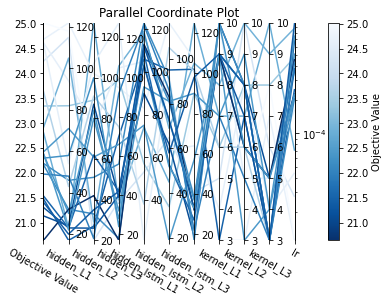

In [22]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["kernel_L1", "kernel_L2", "kernel_L3",
                                                                        'hidden_L1','hidden_L2','hidden_L3',
                                                                        'hidden_lstm_L1', 'hidden_lstm_L2' , 'hidden_lstm_L3', "lr" ])
optuna.visualization.plot_param_importances(study)

In [23]:
#Download the PT file
from google.colab import files
files.download('CNNLSTMP.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
#Read the pk file
model = CNNLSTMATT(input_dim = 9, 
                output_dim = 24, 
                kernel_size1 = 9, 
                kernel_size2 = 6,
                kernel_size3 = 5,
                n_channels1 = 32, 
                n_channels2 = 42,
                n_channels3 = 17,
                hidden_size1 = 113,
                hidden_size2 = 83,
                hidden_size3 = 32,
                seq_len=24*5).cuda()

model.load_state_dict(torch.load("CNNLSTMP.pt"))

<All keys matched successfully>

In [25]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [26]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [27]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   95.719510853591
R^2                :        0.9820226267960958
Mean Absolute Error:        75.34187170867285
MAPE               :        0.012460608889334155


error for next 2 hour prediction
Root Mean Squared Error :   123.47492257147597
R^2                :        0.9721287192806428
Mean Absolute Error:        97.69822051621013
MAPE               :        0.016149347973688947


error for next 3 hour prediction
Root Mean Squared Error :   142.1522931386297
R^2                :        0.9641191415349655
Mean Absolute Error:        112.95231740583824
MAPE               :        0.0186480894725506


error for next 24 hour prediction
Root Mean Squared Error :   229.32850250459845
R^2                :        0.8849220410997368
Mean Absolute Error:        190.44703401308945
MAPE               :        0.031928074551699374


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


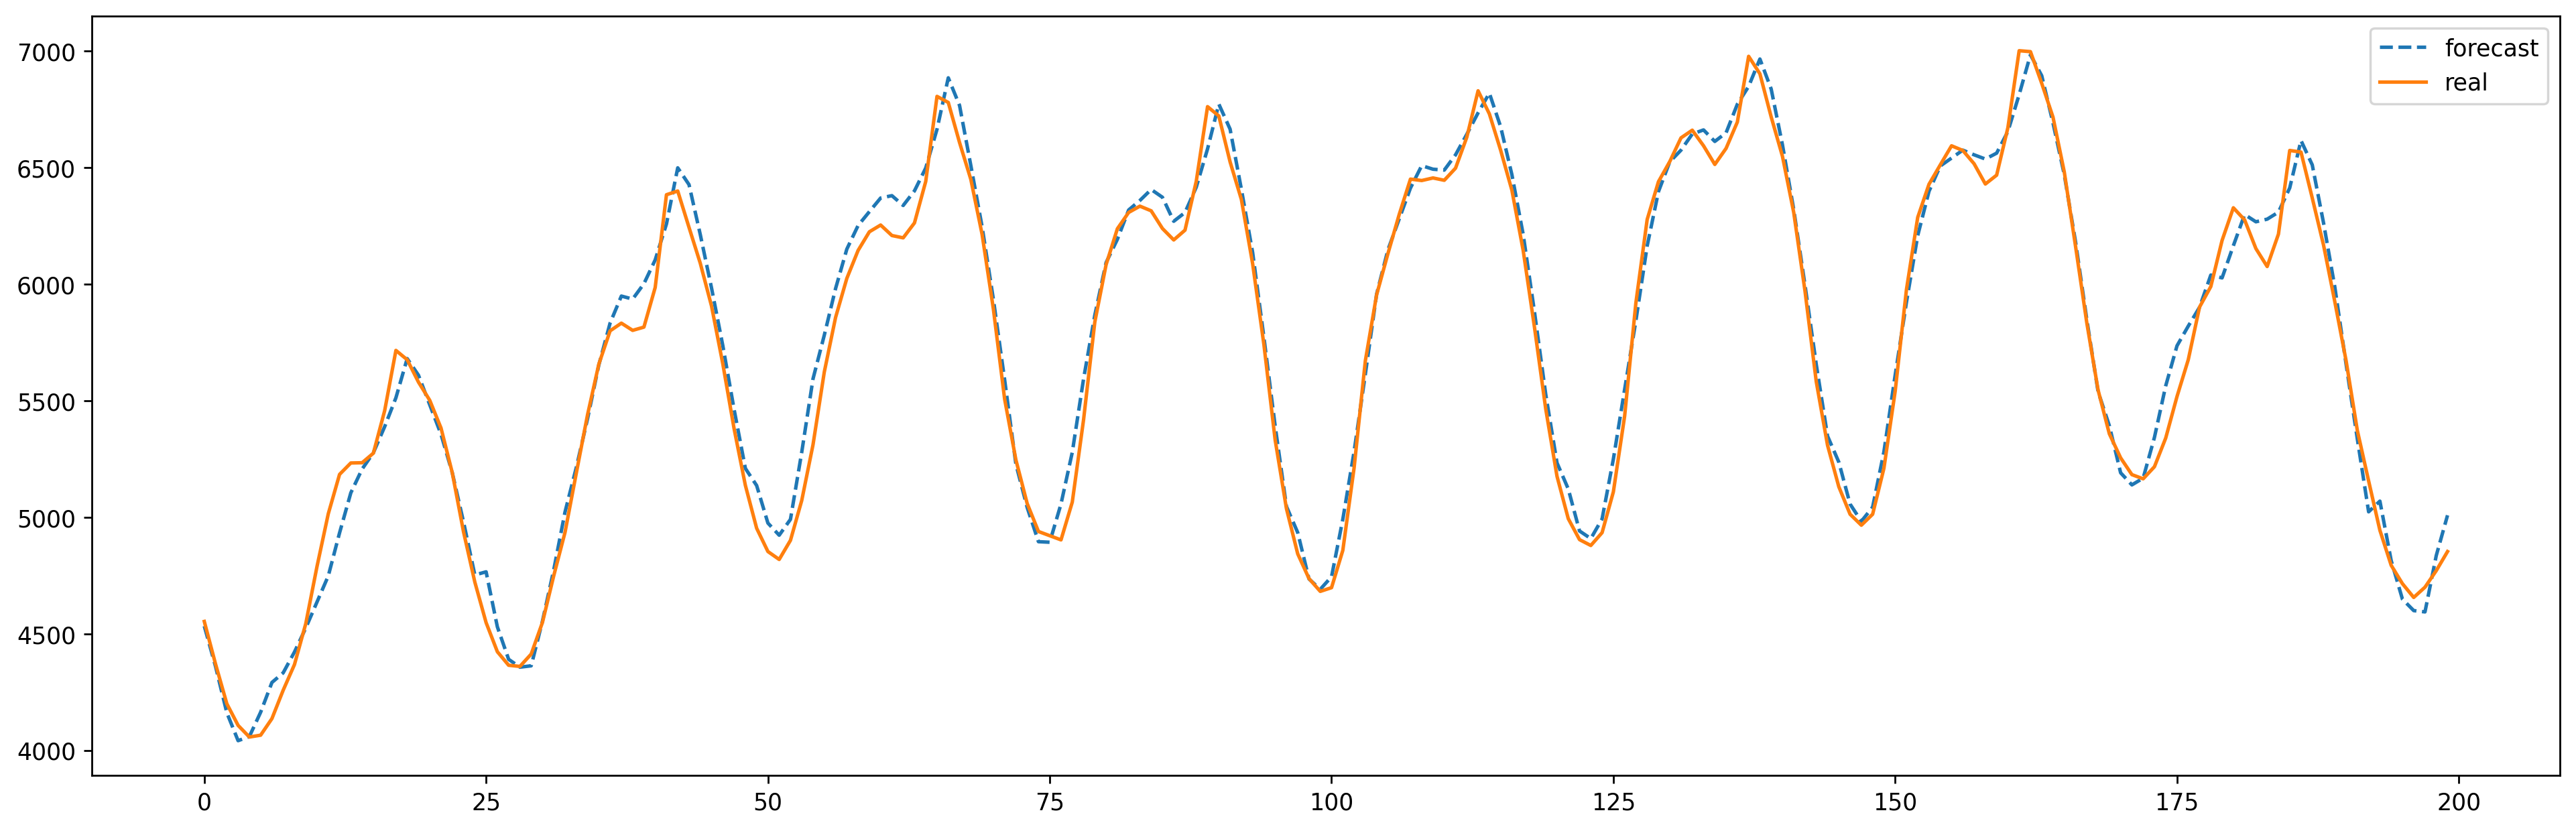

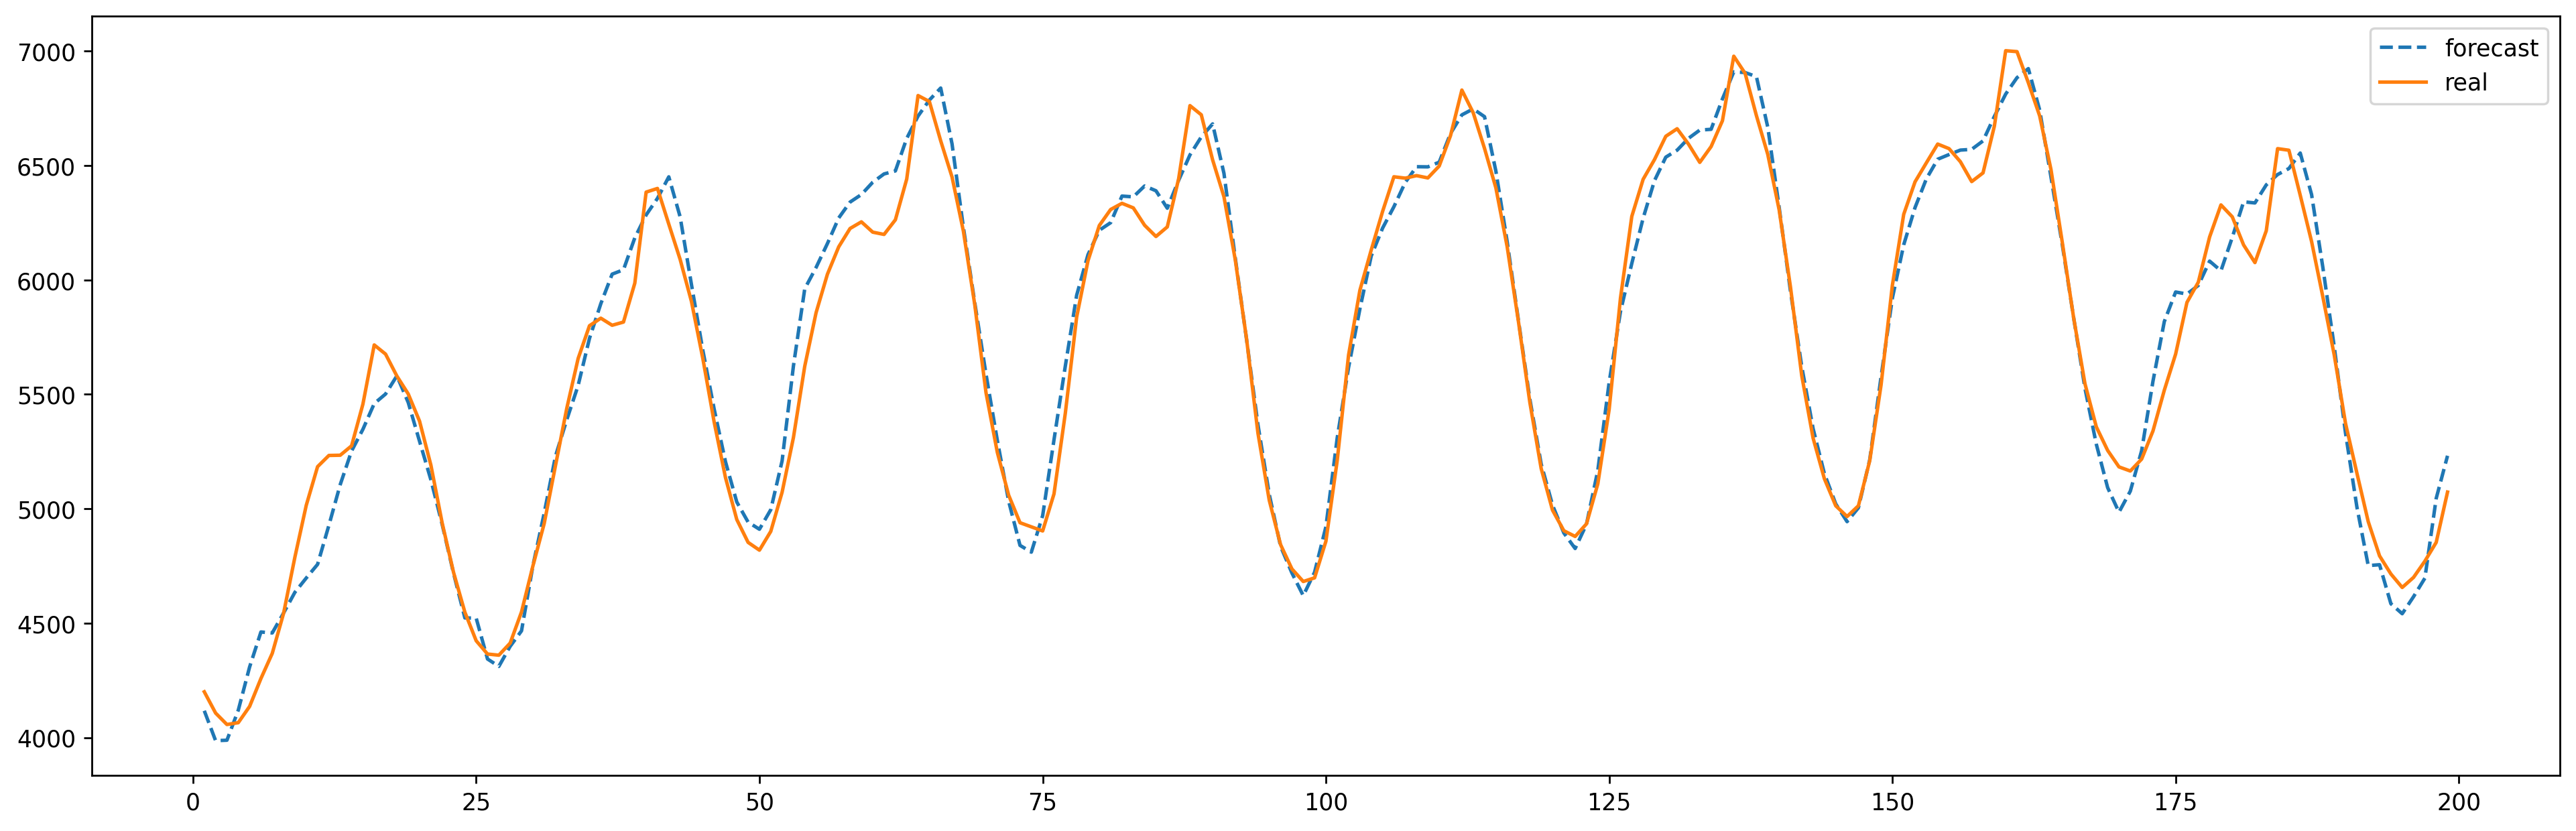

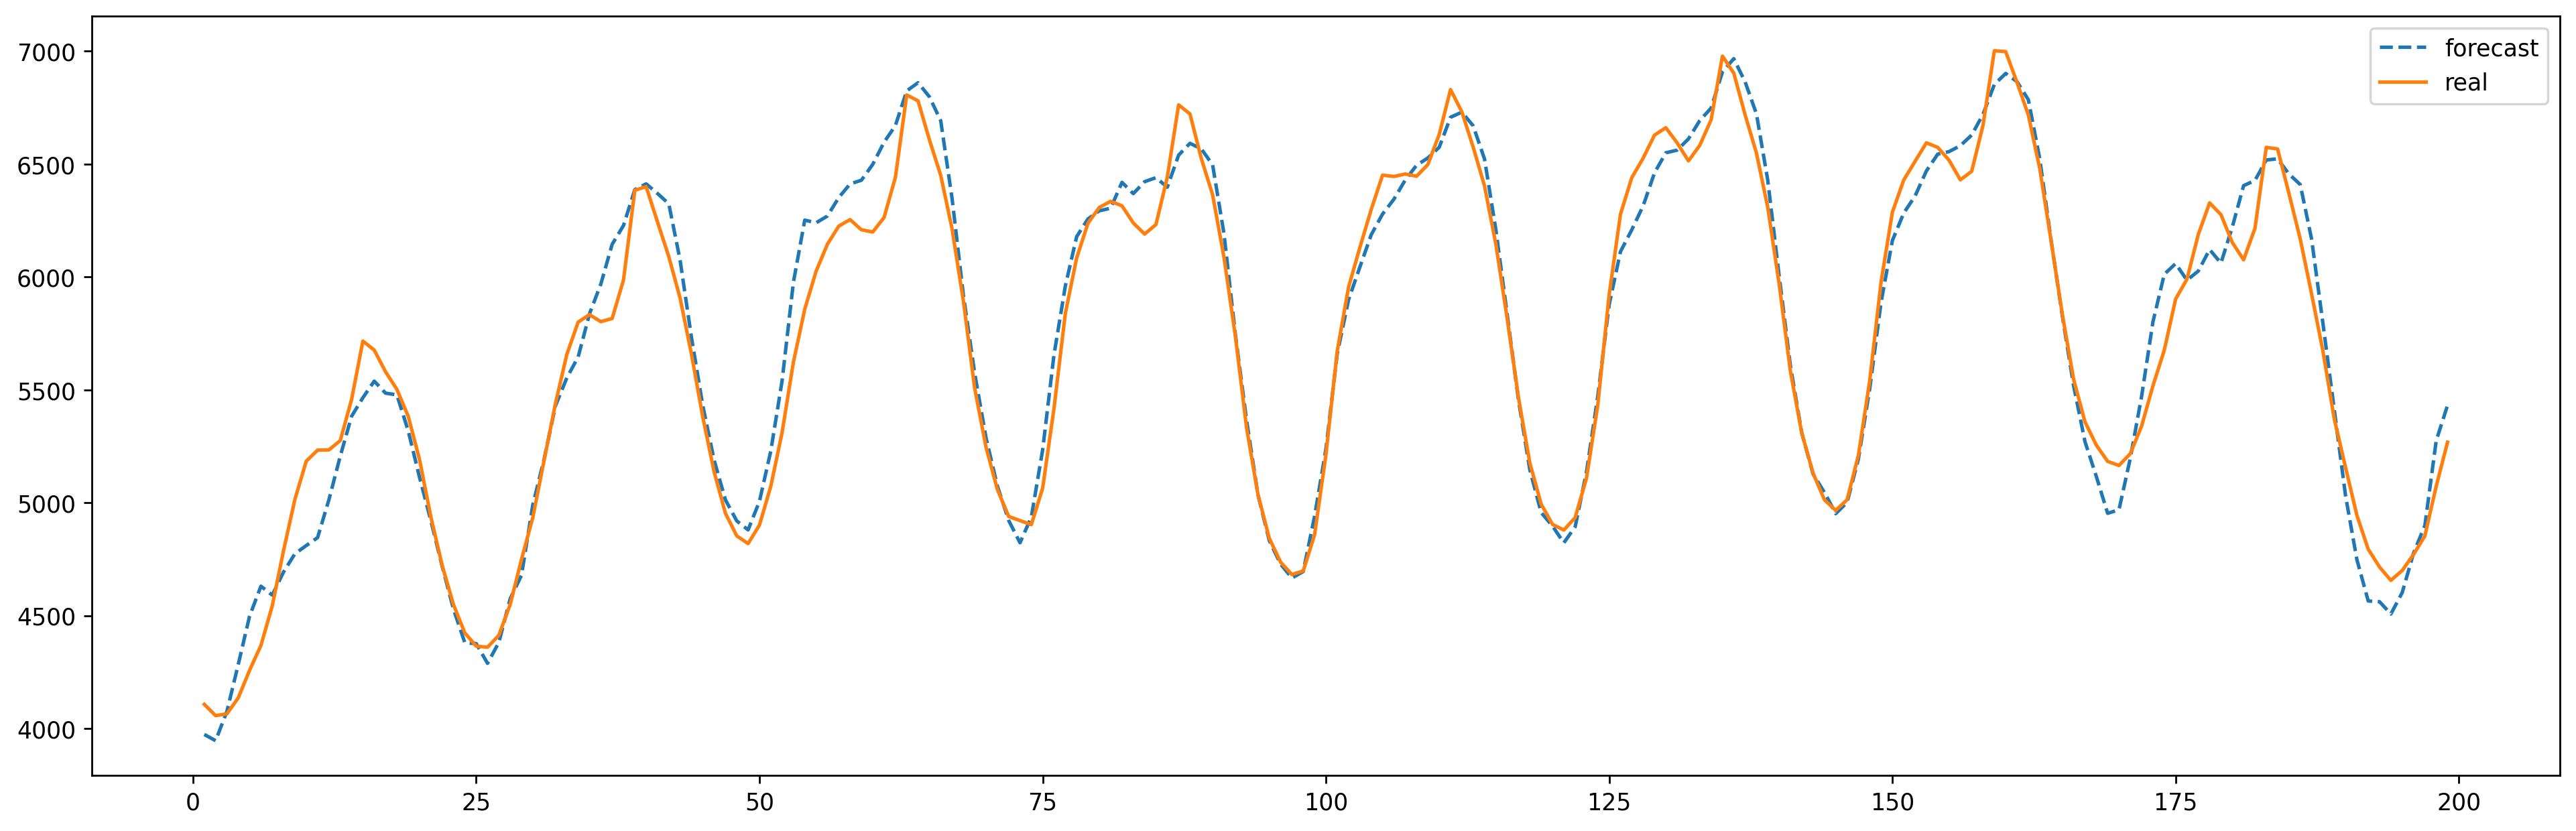

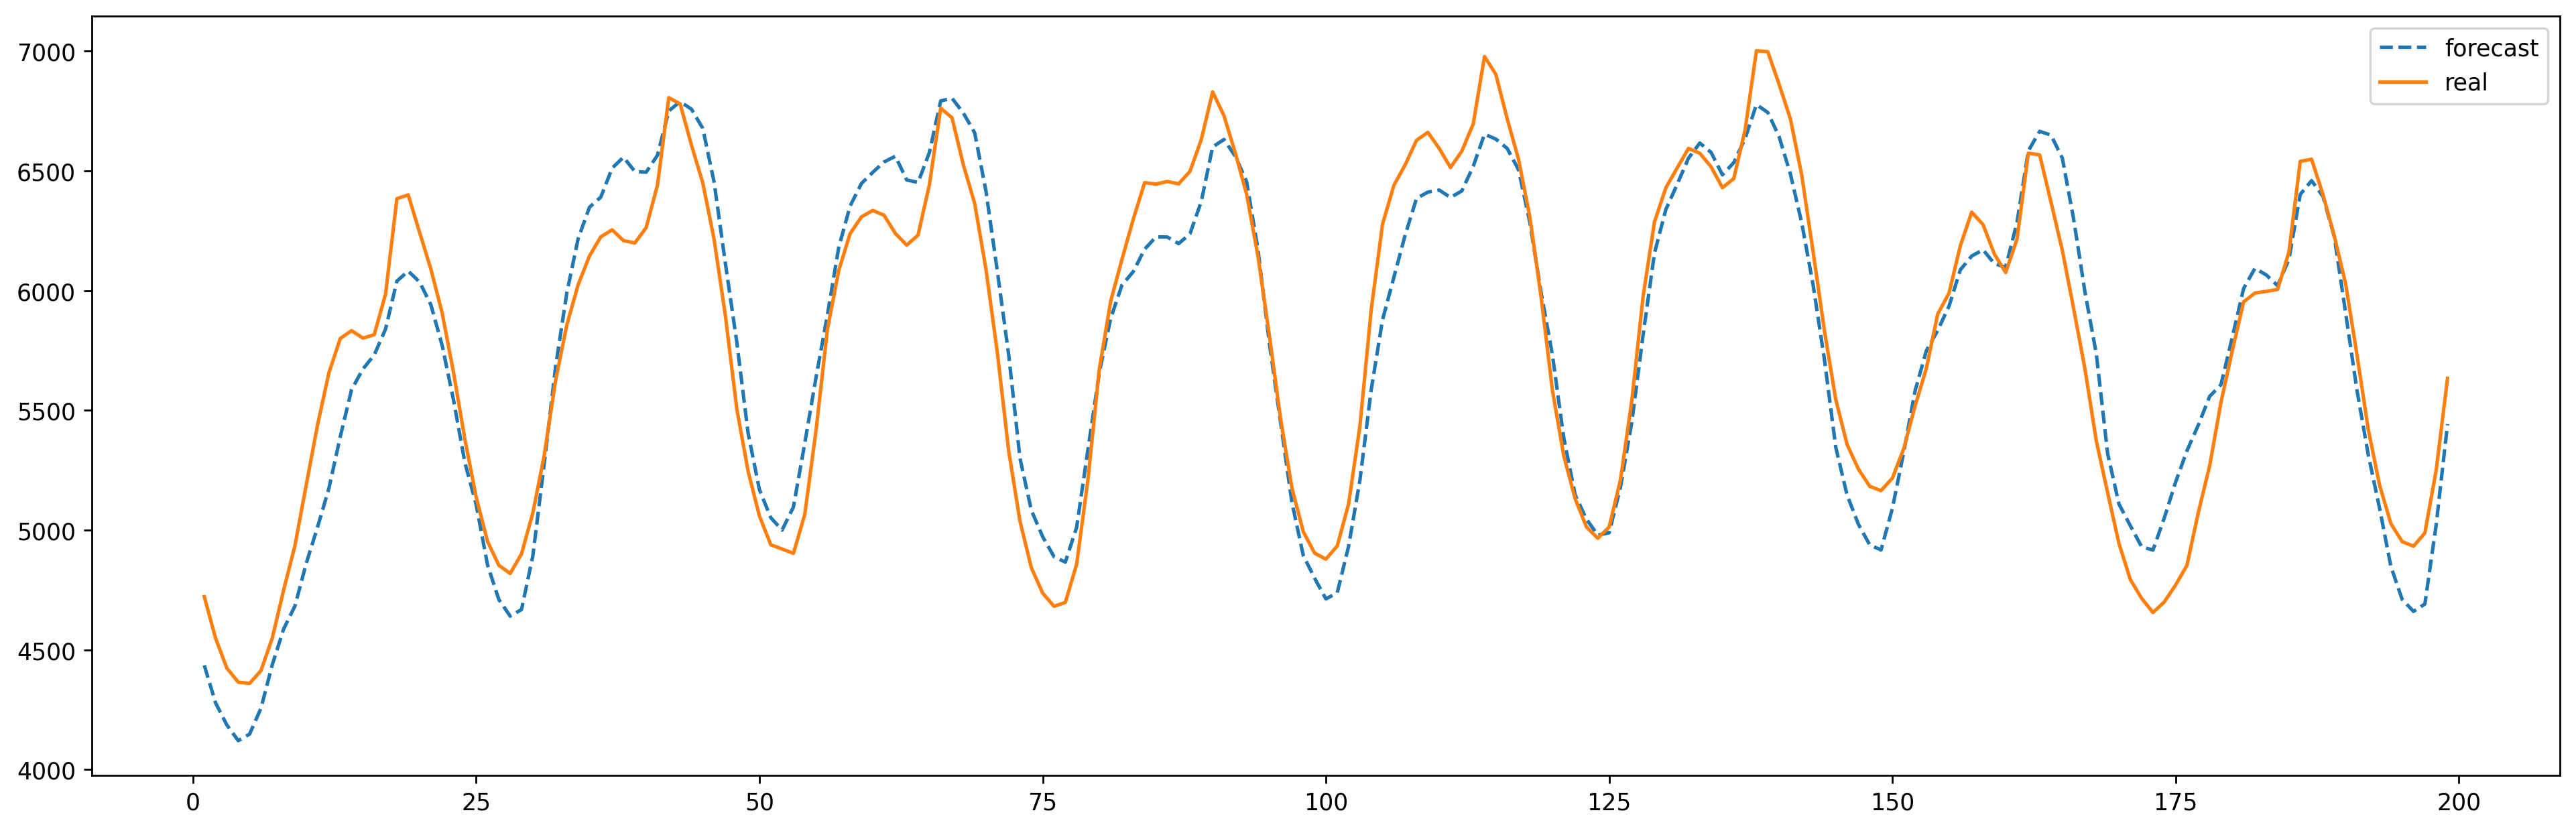

In [28]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the series (the next 24-hour forecast for a specific day)

In [29]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

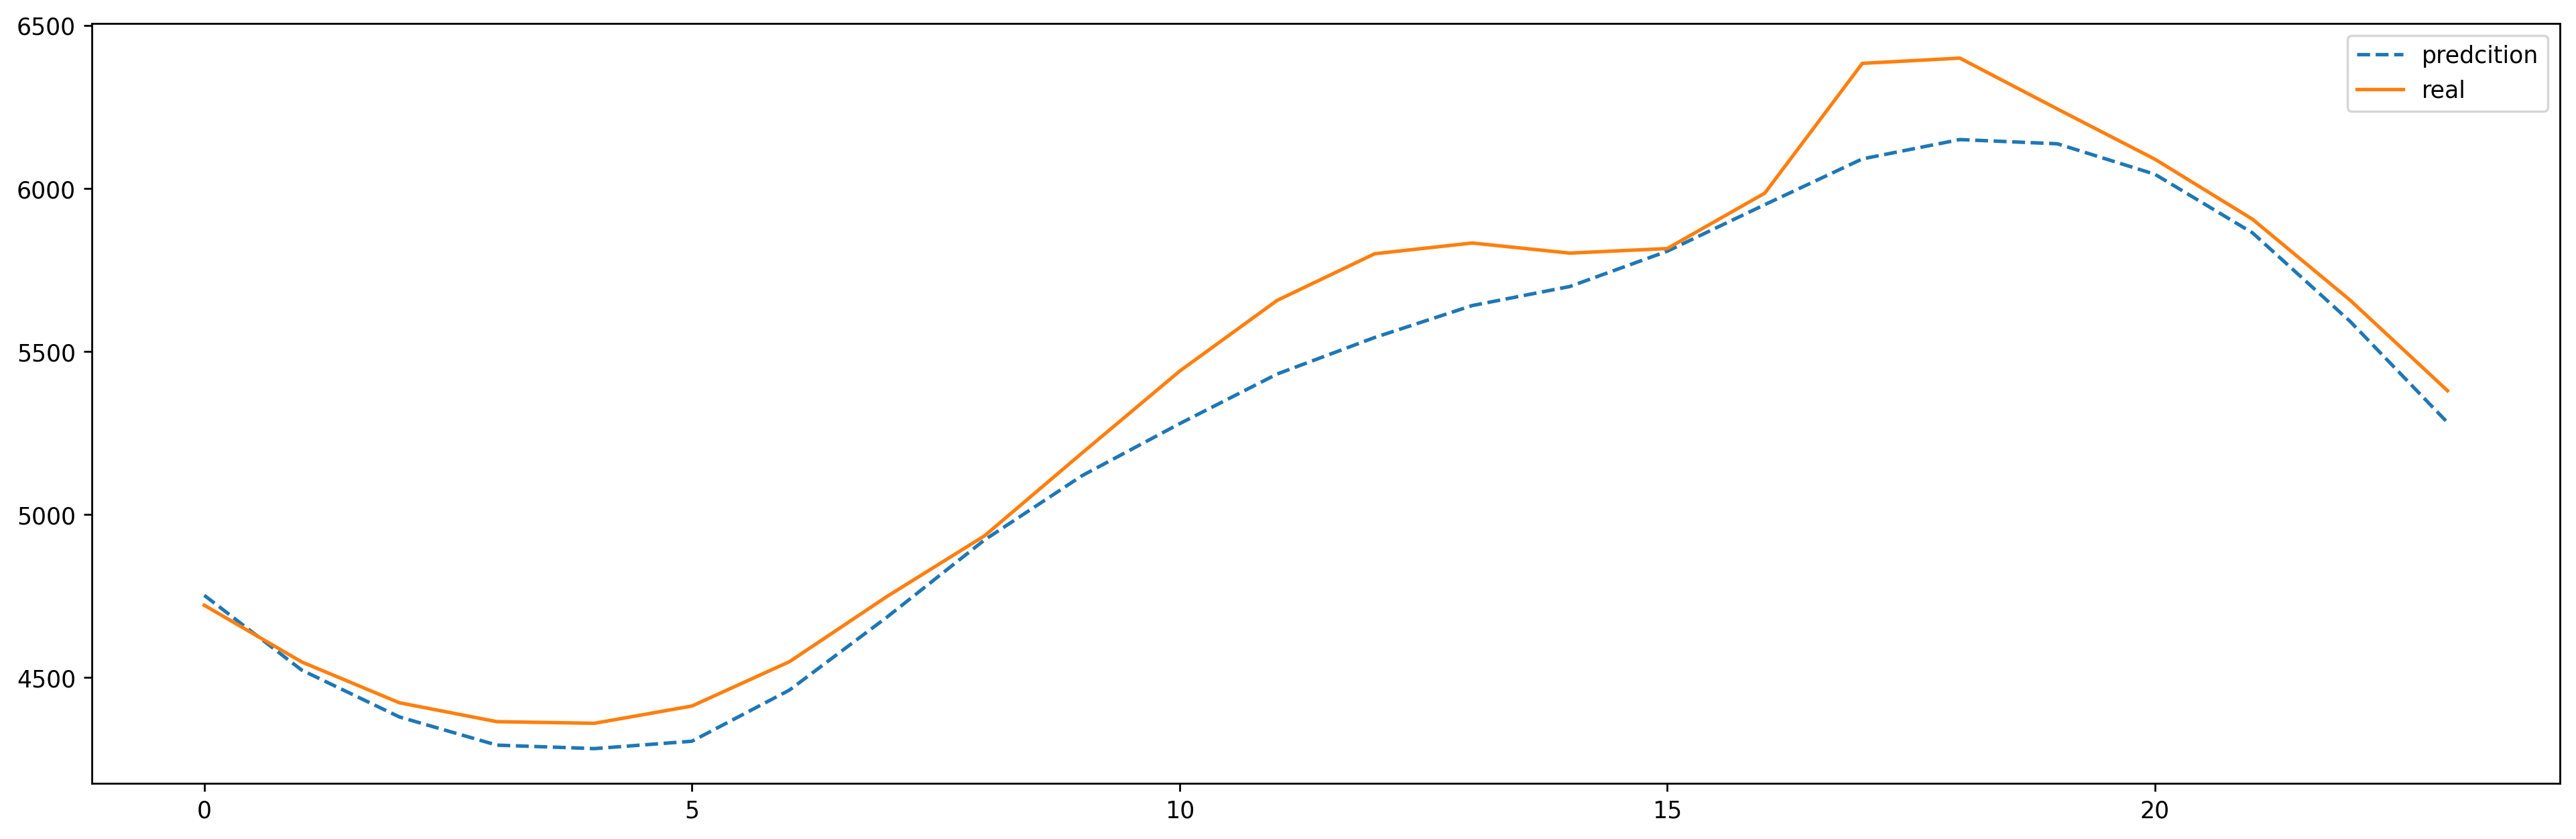

In [30]:
figure(figsize=(19, 6), dpi=250)

#select the day to forecast
day=1

dates = range(len(prediction_descaled))
plt.plot(dates[0:24], prediction_descaled[day*24] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[day*24], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();